In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

def sod_tube(x, t, left_state, right_state, gamma):
    rho_L, p_L, u_L = left_state
    rho_R, p_R, u_R = right_state
    
    a_L = np.sqrt(gamma * p_L / rho_L)
    a_R = np.sqrt(gamma * p_R / rho_R)
    
    def pressure_func(p_star, rho, p, a):
        if p_star > p:
            A = 2 / ((gamma + 1) * rho)
            B = (gamma - 1) / (gamma + 1) * p
            return (p_star - p) * np.sqrt(A / (p_star + B))
        else:
            return 2 * a / (gamma - 1) * (1 - (p_star / p)**((gamma - 1) / (2 * gamma)))

    def residual(p_star):
        return pressure_func(p_star, rho_L, p_L, a_L) - pressure_func(p_star, rho_R, p_R, a_R)
    
    def residual_squared(p_star):
        return residual(p_star)**2

    result = minimize_scalar(residual_squared, bounds=(1e-6, 1e6), method='bounded')
    p_star = result.x
    u_star = u_L + pressure_func(p_star, rho_L, p_L, a_L)
    
    rho_star_L = rho_L * (p_star / p_L + (gamma - 1) / (gamma + 1)) / ((gamma - 1) / (gamma + 1) * p_star / p_L + 1)
    rho_star_R = rho_R * (p_star / p_R + (gamma - 1) / (gamma + 1)) / ((gamma - 1) / (gamma + 1) * p_star / p_R + 1)
    
    rho = np.empty_like(x)
    p = np.empty_like(x)
    u = np.empty_like(x)
    
    for i, xi in enumerate(x):
        if xi / t < u_star:
            if p_star > p_L:
                shock_speed = u_L - a_L * np.sqrt((gamma + 1) / (2 * gamma) * (p_star / p_L - 1) + 1)
                if xi / t > shock_speed:
                    rho[i], p[i], u[i] = rho_L, p_L, u_L
                else:
                    rho[i], p[i], u[i] = rho_star_L, p_star, u_star
            else:
                head_speed = u_L - a_L
                tail_speed = u_star - a_L * (p_star / p_L)**((gamma - 1) / (2 * gamma))
                if xi / t > head_speed:
                    rho[i], p[i], u[i] = rho_L, p_L, u_L
                elif xi / t > tail_speed:
                    #wrong
                    rho[i] = rho_L * (2 / (gamma + 1) - (gamma - 1) * (u_L - xi / t) / ((gamma + 1) * a_L))**(2 / (gamma - 1))
                    p[i] = p_L * (rho[i] / rho_L)**gamma
                    #
                    u[i] = u_L - a_L * (1 - (rho[i] / rho_L)**((gamma - 1) / (2 * gamma)))
                else:
                    rho[i], p[i], u[i] = rho_star_L, p_star, u_star
        else:
            if p_star > p_R:
                shock_speed = u_R + a_R * np.sqrt((gamma + 1) / (2 * gamma) * (p_star / p_R - 1) + 1)
                if xi / t < shock_speed:
                    rho[i], p[i], u[i] = rho_R, p_R, u_R
                else:
                    rho[i], p[i], u[i] = rho_star_R, p_star, u_star
            else:
                head_speed = u_R + a_R
                tail_speed = u_star + a_R * (p_star / p_R)**((gamma - 1) / (2 * gamma))
                if xi / t < head_speed:
                    rho[i], p[i], u[i] = rho_R, p_R, u_R
                elif xi / t < tail_speed:
                    #wrong
                    rho[i] = rho_R * (2 / (gamma + 1) + (gamma - 1) * (u_R - xi / t) / ((gamma + 1) * a_R))**(2 / (gamma - 1))
                    p[i] = p_R * (rho[i] / rho_R)**gamma
                    #
                    u[i] = u_R + a_R * (1 - (rho[i] / rho_R)**((gamma - 1) / (2 * gamma)))
                else:
                    rho[i], p[i], u[i] = rho_star_R, p_star, u_star
                    
    return rho, p, u

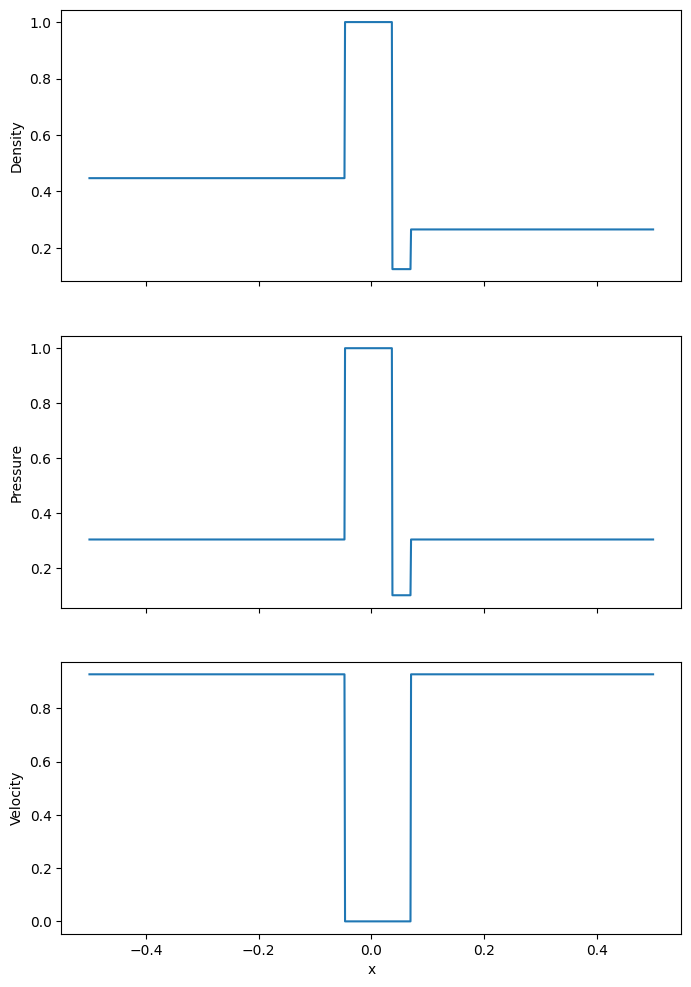

In [12]:
# Define the initial conditions and parameters
left_state = (1.0, 1.0, 0.0)
right_state = (0.125, 0.1, 0.0)
gamma = 1.4
t = 0.04
x = np.linspace(-0.5, 0.5, 1000)

# Compute the solution
rho, p, u = sod_tube(x, t, left_state, right_state, gamma)

# Plot the solution
fig, ax = plt.subplots(3, 1, figsize=(8, 12), sharex=True)
ax[0].plot(x, rho)
ax[0].set_ylabel("Density")
ax[1].plot(x, p)
ax[1].set_ylabel("Pressure")
ax[2].plot(x, u)
ax[2].set_ylabel("Velocity")
ax[2].set_xlabel("x")

plt.show()

In [5]:
from nm_lib import nm_lib as nm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [6]:
class HydroSolver1D():
    def __init__(self, n):
        self.n = n
        self.xx = np.linspace(0, 1, n)
        
        self.rho = np.zeros(n)
        self.ux = np.zeros(n)
        self.uy = np.zeros(n)
        self.uz = np.zeros(n)
        self.e = np.zeros(n)
        self.Pg = np.zeros(n)
        
        self.gamma = 5/3
        self.check_intital_conditions()
        self.calculate_inital_conditions()

    def check_intital_conditions(self):
        assert hasattr(self, "calculate_inital_conditions"), "You need to define a function called calculate_inital_conditions"

    def get_sound_speed(self):
        #ideal gas assumption
        cs = np.sqrt(self.gamma * self.Pg/self.rho)
        return cs
    
    def update_rho(self, dt):
        ux = self.ux
        rho = self.rho
        
        #Lax scheme
        rhs = -nm.deriv_cent(self.xx, rho*ux)
        hh = 1/3 *  (np.roll(rho, -1) + rho + np.roll(rho, +1)) + rhs * dt
        #remove ill calculated points
        hh = hh[1:-1]
        #padding
        hh = np.pad(hh, pad_width=[1,1] ,mode="edge")
        return hh
    
    def update_ux(self, dt):
        ux = self.ux
        rho = self.rho
        Pg = self.Pg
        
        #Lax scheme
        rhs = -nm.deriv_cent(self.xx, rho*ux*ux) - nm.deriv_cent(self.xx, Pg)
        hh = 1/3 * (np.roll(rho*ux, -1) +rho*ux + np.roll(rho*ux, +1)) + rhs * dt
        #remove ill calculated points
        hh = hh[1:-1]
        #padding
        hh = np.pad(hh, pad_width=[1,1] ,mode="edge")
        return hh/rho
    
    def update_uy(self, dt):
        xx = self.xx
        rho = self.rho
        ux = self.ux
        uy = self.uy
        
        #Lax scheme
        rhs = - nm.deriv_cent(xx, rho*ux*uy)
        hh = 1/3 * (np.roll(rho*uy, -1) +rho*uy + np.roll(rho*uy, +1)) + rhs * dt
        #remove ill calculated points
        hh = hh[1:-1]
        #padding
        hh = np.pad(hh, pad_width=[1,1] ,mode="edge")
        return hh/rho
    
    def update_uz(self, dt):
        xx = self.xx
        rho = self.rho
        ux = self.ux
        uz = self.uz
        
        #Lax scheme
        rhs = - nm.deriv_cent(xx, rho*ux*uz)
        hh = 1/3 * (np.roll(rho*uz, -1) +rho*uz + np.roll(rho*uz, +1)) + rhs * dt
        #remove ill calculated points
        hh = hh[1:-1]
        #padding
        hh = np.pad(hh, pad_width=[1,1] ,mode="edge")
        return hh/rho   

    def update_e(self, dt):
        ux = self.ux
        e = self.e
        Pg = self.Pg
        #Lax scheme
        rhs = - nm.deriv_cent(self.xx, e*ux) - Pg*nm.deriv_cent(self.xx, ux)
        hh = 1/3 * (np.roll(e, -1) + e + np.roll(e, +1)) + rhs * dt
        #remove ill calculated points
        hh = hh[1:-1]
        #padding
        hh = np.pad(hh, pad_width=[1,1] ,mode="edge")
        return hh

    def calculate_dt(self, cfl_cut):
        #cfl condition
        cs = self.get_sound_speed()
        dt1 = cfl_cut * nm.cfl_adv_burger(self.ux+cs, self.xx)
        dt2 = cfl_cut * nm.cfl_adv_burger(cs, self.xx)
        return np.min([dt1, dt2])

    
    def step(self, cfl_cut):
        dt = self.calculate_dt(cfl_cut)
        
        self.rho = self.update_rho(dt)
        self.ux = self.update_ux(dt)
        self.uy = self.update_uy(dt)
        self.uz = self.update_uz(dt)
        self.e = self.update_e(dt)
        
        self.Pg = (self.gamma-1) * self.e / self.rho
        
        return dt

In [ ]:
def analytical_solution(rho1, rho5, p1, p5):
    Gamma = (gamma-1)/(2*gamma)
    p4 = p3
    rho4 = rho5 * (p4+Gamma*p5)/(p5+Gamma*p4)

In [8]:
def interval_shift(x,a,b,c,d):
    #shifts [a,b] onto [c,d] for interval x
    return c + (d-c)/(b-a) *(x-a)

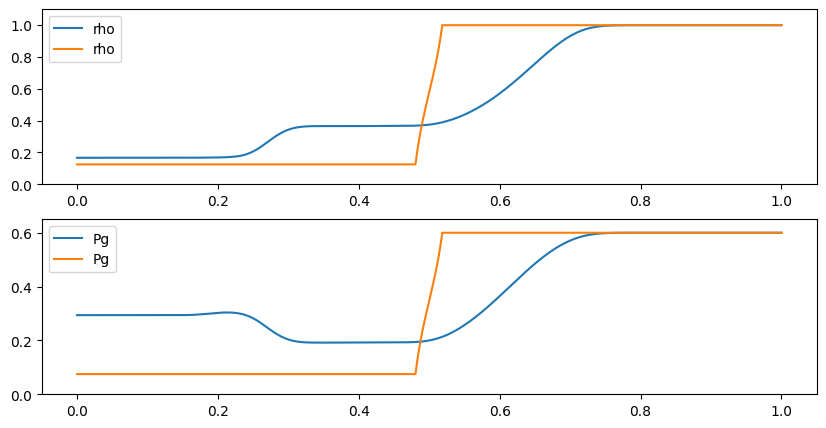

In [9]:
def calculate_inital_conditions(self):
    self.rho[:int(self.n/2)] = 0.125
    self.rho[int(self.n/2):] = 1
    
    self.Pg[:int(self.n/2)] = 0.125/self.gamma
    self.Pg[int(self.n/2):] = 1/self.gamma
    
    #smoothing middle with tangens
    smooth_left = 0.48
    smooth_right = 0.52
    
    smooth_starpoint = np.argmin(np.abs(self.xx-smooth_left))
    smooth_endpoint = np.argmin(np.abs(self.xx-smooth_right))
    
    mapped_xx = interval_shift(self.xx[smooth_starpoint:smooth_endpoint], smooth_left, smooth_right, -np.pi/4, np.pi/4)
    
    tan_func = np.tan(mapped_xx)
    
    pressure = interval_shift(tan_func, np.min(tan_func), np.max(tan_func), 0.125/self.gamma, 1/self.gamma)
    
    self.Pg[smooth_starpoint:smooth_endpoint] = pressure
    
    density = interval_shift(tan_func, np.min(tan_func), np.max(tan_func), 0.125, 1)

    self.rho[smooth_starpoint:smooth_endpoint] = density

    self.e = self.Pg / (self.gamma-1) * self.rho

HydroSolver1D.calculate_inital_conditions = calculate_inital_conditions

nx = 1000
hd = HydroSolver1D(nx)

nt = 1000

plot_points = 100

rho = np.zeros((nt, nx))
P = np.zeros((nt, nx))
ux = np.zeros((nt,nx))
uy = np.zeros((nt,nx))
uz = np.zeros((nt,nx))
e = np.zeros((nt,nx))
rho[0][:] = hd.rho
P[0][:] = hd.Pg

for i in range(1, nt):
    hd.step(cfl_cut=0.5)
    rho[i][:] = hd.rho
    P[i][:] = hd.Pg
    ux[i][:] = hd.ux
    uy[i][:] = hd.uy
    uz[i][:] = hd.uz



fig, ax = plt.subplots(nrows=2, figsize=(10, 5))
def init():
    ax[0].plot(hd.xx, rho[0,:], label="rho")
    ax[1].plot(hd.xx, P[0,:], label="Pg")
    ax[0].legend()
    ax[1].legend()
    ax[0].set_ylim(0,1.1)
    ax[1].set_ylim(0,0.65)

def animate(i):
    ax[0].clear()
    ax[1].clear()
    ax[0].plot(hd.xx, rho[i,:], label="rho")
    ax[1].plot(hd.xx, P[i,:], label="Pg")
    ax[0].legend()
    ax[1].legend()
    ax[0].set_ylim(0,1.1)
    ax[1].set_ylim(0,0.65)
    

anim = FuncAnimation(fig, animate, interval=100, frames=np.linspace(0, nt - 1, plot_points, endpoint=False, dtype=int), init_func=init)
HTML(anim.to_jshtml())

In [57]:
class MDHsolver1D(HydroSolver1D):
    def __init__(self, n):
        self.n = n
        self.xx = np.linspace(0, 1, n)
        
        self.rho = np.zeros(n)
        self.ux = np.zeros(n)
        self.uy = np.zeros(n)
        self.uz = np.zeros(n)
        self.e = np.zeros(n)
        
        self.Bx = np.zeros(n)
        self.By = np.zeros(n)
        self.Bz = np.zeros(n)

        self.Pg = np.zeros(n)
        self.gamma = 5/3
        self.check_intital_conditions()
        self.calculate_inital_conditions()
        
    def update_ux(self, dt):
        xx = self.xx
        ux = self.ux
        rho = self.rho
        Pg = self.Pg
        By = self.By
        Bz = self.Bz
        
        deriv_B =  Bz*nm.deriv_cent(xx, Bz) + By*nm.deriv_cent(xx, By)
        
        rhs = -nm.deriv_cent(self.xx, rho*ux*ux) - nm.deriv_cent(self.xx, Pg) - deriv_B
        #Lax
        hh = 1/3 * (np.roll(rho*ux, -1) +rho*ux + np.roll(rho*ux, +1)) + rhs * dt
        #remove ill calculated points
        hh = hh[1:-1]
        #padding
        hh = np.pad(hh, pad_width=[1,1] ,mode="edge")
        return hh/rho
    
    def update_uy(self, dt):
        xx = self.xx
        rho = self.rho
        ux = self.ux
        uy = self.uy
        Bx = self.Bx
        By = self.By
        
        #Lax scheme
        rhs = - nm.deriv_cent(xx, rho*ux*uy) + Bx * nm.deriv_cent(xx, By)
        hh = 1/3 * (np.roll(rho*uy, -1) +rho*uy + np.roll(rho*uy, +1)) + rhs * dt
        #remove ill calculated points
        hh = hh[1:-1]
        #padding
        hh = np.pad(hh, pad_width=[1,1] ,mode="edge")
        return hh/rho
    
    def update_uz(self, dt):
        xx = self.xx
        rho = self.rho
        ux = self.ux
        uz = self.uz
        Bx = self.Bx
        Bz = self.Bz
        
        #Lax scheme
        rhs = - nm.deriv_cent(xx, rho*ux*uz) + Bx * nm.deriv_cent(xx, Bz)
        hh = 1/3 * (np.roll(rho*uz, -1) +rho*uz + np.roll(rho*uz, +1)) + rhs * dt
        #remove ill calculated points
        hh = hh[1:-1]
        #padding
        hh = np.pad(hh, pad_width=[1,1] ,mode="edge")
        return hh/rho  
    
    def update_Bx(self, dt):
        return self.Bx
    
    def update_By(self, dt):
        xx = self.xx
        Bx = self.Bx
        By = self.By
        ux = self.ux
        uy = self.uy
        
        rhs = -nm.deriv_cent(xx, By*ux) + nm.deriv_cent(xx, Bx*uy)
        
        hh = 1/3 * (np.roll(By, -1) +By + np.roll(By, +1)) + rhs * dt
        hh = hh[1:-1]
        hh = np.pad(hh, pad_width=[1,1] ,mode="edge")
        return hh
    
    def update_Bz(self, dt):
        xx = self.xx
        ux = self.ux
        uz = self.uz
        Bx = self.Bx
        Bz = self.Bz
        rhs = nm.deriv_cent(xx, ux*Bz) - nm.deriv_cent(xx, uz*Bx)

        hh = 1/3 * (np.roll(Bz, -1) +Bz + np.roll(Bz, +1)) + rhs * dt
        hh = hh[1:-1]
        hh = np.pad(hh, pad_width=[1,1] ,mode="edge")
        return hh    
    
    def step(self, cfl_cut):
        dt = self.calculate_dt(cfl_cut)
        
        self.rho = self.update_rho(dt)
        self.ux = self.update_ux(dt)
        self.uy = self.update_uy(dt)
        self.uz = self.update_uz(dt)
        self.e = self.update_e(dt)
        self.Bx = self.update_Bx(dt)
        self.By = self.update_By(dt)
        self.Bz = self.update_Bz(dt)
        
        self.Pg = (self.gamma-1) * self.e / self.rho
        
        return dt

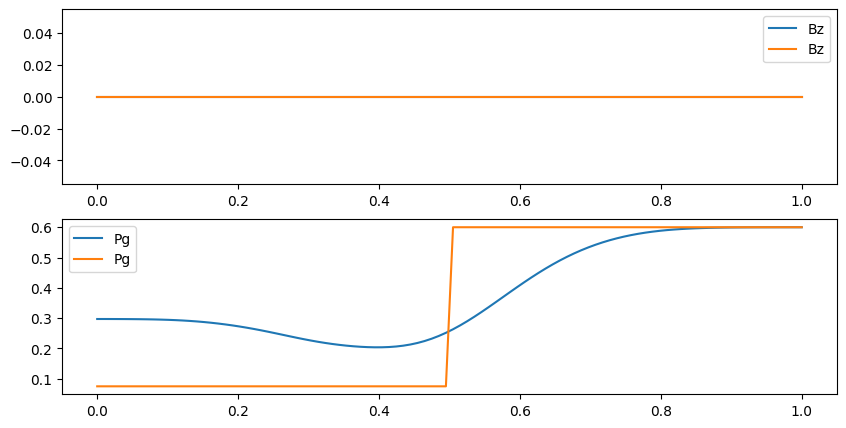

In [58]:
def calculate_inital_conditions(self):
    self.rho[:int(self.n/2)] = 0.125
    self.rho[int(self.n/2):] = 1

    self.Pg[:int(self.n/2)] = 0.125/self.gamma
    self.Pg[int(self.n/2):] = 1/self.gamma

    self.e = self.Pg / (self.gamma-1) * self.rho

MDHsolver1D.calculate_inital_conditions = calculate_inital_conditions

nx = 100
mhd = MDHsolver1D(nx)

nt = 100
rho = np.zeros((nt, nx))
P = np.zeros((nt, nx))
ux = np.zeros((nt,nx))
e = np.zeros((nt,nx))

Bx = np.zeros((nt,nx))
By = np.zeros((nt,nx))
Bz = np.zeros((nt,nx))

rho[0][:] = mhd.rho
P[0][:] = mhd.Pg
Bz[0][:] = mhd.Bz


for i in range(1, nt):
    mhd.step(cfl_cut=0.5)
    rho[i][:] = mhd.rho
    P[i][:] = mhd.Pg
    Bz[i][:] = mhd.Bz



fig, ax = plt.subplots(nrows=2, figsize=(10, 5))
def init():
    ax[0].plot(mhd.xx, Bz[0,:], label="Bz")
    ax[1].plot(mhd.xx, P[0,:], label="Pg")
    ax[0].legend()
    ax[1].legend()

def animate(i):
    ax[0].clear()
    ax[1].clear()
    ax[0].plot(mhd.xx, Bz[i,:], label="Bz")
    ax[1].plot(mhd.xx, P[i,:], label="Pg")
    ax[0].legend()
    ax[1].legend()

anim = FuncAnimation(fig, animate, interval=100, frames=nt, init_func=init)
HTML(anim.to_jshtml())

Bx > 0, make sure magnetic pressure is higher than gas pressure (Bx should then travel at Alfven speed)

Roe shock, compare with other code 

Q: What initial conditions to test with?
Q: What to do next?